In [85]:
# https://github.com/swar/nba_api

# Static headers for cdn requests, these never change
static_headers  = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}


import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import tqdm 
dataset_path = './datasets'

import warnings
warnings.filterwarnings("ignore")

We will be analysing games played in 2019-20 between Denver Nuggets and Los Angeles Lakers. 
Example: https://github.com/swar/nba_api/blob/master/docs/examples/Finding%20Games.ipynb

In [4]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
nba_teams = teams.get_teams()

def get_team_games(team_id: int=None, team_abbr: str=None, season: str=None, opponent_team: str=None): # -> pd.DataFrame:
    """ Get the games for a team, searchable by team_id or team_abbr. Keep only games form the given season.
    @team_id: ID of the team
    @team_abbr: Abbreviation of the team, eg. 'BOS', 'LAL'
    @season: Season in the format 'YYYY', if null then get all games
    @opponent_team: Abbreviation of the opponent team, eg. 'BOS', 'LAL'
    """
    # Find the team id if the team name is given
    if team_abbr:
        team_obj = [team for team in nba_teams if team['abbreviation'] == team_abbr][0]
        team_id = team_obj['id']

    # Get all games for the team in the given season, regular season and playoffs
    try:
        gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id, season_type_nullable='Playoffs,Regular Season', season_nullable=season) 
    except Exception as e:
        print(e)
        return pd.DataFrame()

    games = gamefinder.get_data_frames()[0]
    
    # If opponent team is given, keep only games against that team
    if opponent_team:
        games = games.loc[(games['MATCHUP'].str.contains(opponent_team))]
    return games


We take three random games from the df shown above, each at a different stage in season. We chose the first game in the season, the first game in the playoff and the last game of west conference finals (game 6). <br>
Main endpoint for processing play by play (pbp) data (enter your own game_id)
https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_'game_id'.json


In [5]:
import requests
import pandas as pd

# create function that gets pbp logs from the nba api with game id
def get_pbp_data(game_id):
    play_by_play_url = "https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_"+game_id+".json"
    response = requests.get(url=play_by_play_url, headers=static_headers).json()
    play_by_play = response['game']['actions']
    df = pd.DataFrame(play_by_play)
    df['gameid'] = game_id
    return df

There are 55 columns in the pbp dataframe and around 500 rows, depending on the number of events. Some of them are useless, so we will do some cleaning. 
Columns of interest:
- <b>actionType</b>: what happened (2pt shot, 3pt shot, rebound, turnover)
- subType: additional information about actionType (for a 2pt -> layup/dunk/midrange )
- qualifiers: additional information about actionType (for a 2pt -> pointsinthepaint,2ndchance)
- <b>personId</b>: ID of player - primary id in network
- description: more detailed description of what happened (eg. S. Curry STEAL (1 STL))
- <b>personIdsFilter</b>: IDS of players who were part of the play (eg. K. Thompson 27' 3PT  (3 PTS) (K. Looney 1 AST) -> 202691,1626172)
- playerName: last name of player, used for labels in networks
- shotResult: sucess of  the shot (Made, Missed)
- <b>assistPersonId</b>: ID of player who asisted a shot

In [6]:
def get_pbp(game_id, save_pickle=False, save_csv = False):
    # Try loading the pbp from pickle
    try:
        pbp = pd.read_pickle('pbp_'+game_id+'.pkl')
    except:
        pbp = get_pbp_data(game_id)
        # Save the pbp to pickle
        with open('pbp_'+game_id+'.pkl', 'wb') as f:
            pickle.dump(pbp, f)
        

    if save_pickle:
        with open('pbp_'+game_id+'.pkl', 'wb') as f:
            pickle.dump(pbp, f)
    if save_csv:
        pbp.to_csv(dataset_path+'/pbp_'+game_id+'.csv')

    # Remove some columns
    col_rem = ['x', 'y', 'edited', 'xLegacy', 'yLegacy', 'side', 'playerName', 
            'officialId', 'jumpBallRecoveredName', 'jumpBallRecoverdPersonId',
            'jumpBallWonPlayerName', 'jumpBallWonPersonId', 'jumpBallLostPlayerName',
            'jumpBallLostPersonId']
    # Drop them if they exist
    pbp = pbp.drop(columns=col_rem, errors='ignore')

    # Change some column names
    col_rename = {'assistPlayerNameInitial': 'assistPlayer', 'playerNameI': 'playerName'}
    pbp = pbp.rename(columns=col_rename)

    # Change teamId to int if they are not nan
    pbp['teamId'] = pbp['teamId'].apply(lambda x: int(x) if not pd.isnull(x) else x)
    pbp['personId'] = pbp['personId'].apply(lambda x: int(x) if not pd.isnull(x) else x)
    pbp['assistPersonId'] = pbp['assistPersonId'].apply(lambda x: int(x) if not pd.isnull(x) else x)

    return pbp

In [7]:
def get_team_network(team_ids: list, pbp):
    """
    @team_ids: List of team ids, eg. [1610612744, 1610612745]
    """
    network_dict = {team_id: nx.MultiDiGraph() for team_id in team_ids}

    for id in team_ids:
        # Add two nodes for shot result
        network_dict[id].add_node(1, playerName='Made', shot_result='Made', teamId=0)
        network_dict[id].add_node(2, playerName='Missed', shot_result='Missed', teamId=0)

    # Iterate through the rows and print the description
    for index, row in pbp.iterrows():
        # Add only team events
        if row['teamId'] == row['teamId']:

            # Create a node for each player and add it to the graph
            if row['personId']:
                # Add the player to the team network
                network_dict[row['teamId']].add_node(int(row['personId']), playerName=row['playerName'], teamId=int(row['teamId']))

            # Check if event is a shot attempt
            if row['actionType'] in ['3pt', '2pt', 'freethrow']:
                # Get the shooter and assist person ids
                shooter = row['personId']
                connect_to = 1 if row['shotResult'] == 'Made' else 2
                # Connect the shooter to the shot result
                network_dict[row['teamId']].add_edge(shooter, connect_to, action='shot', actionType=row['actionType'], subType = row['subType'], weight = 1)

                # Check if event had an assist
                assist = row['assistPersonId']

                # Check if assist is nan
                if assist == assist:
                    # Add assist node to the graph if not yet added
                    network_dict[row['teamId']].add_node(int(assist), playerName=row['assistPlayer'], teamId=int(row['teamId']))
                    # Connect the assist to the shooter
                    network_dict[row['teamId']].add_edge(int(assist), int(shooter), action='assist', actionType=row['actionType'], weight=1)
        
        
    return network_dict.values()

We can draw a graph for every game for both teams. Edges between players are directed and signify one player assisted the other on a shot attempt. They are weighted based on how many assists these two players had in a game. Edges between players and two central nodes for shot success ('Made', 'Missed') signify that the player attempted a shot. They are weighed based on how many shots the player made/missed and coloured as such. We will use Kamada Kawai graph layout, using distances calculated from shorted path in then network.

In [8]:
SHOT_EDGE_SIZE_DIV =2  # Divisor for shot made edge size
NODE_SIZE_Q = 10                # Multiplier for node size

def convert_asists(multi_graph):
    # Join all assist edges between two players into one edge with weight
    assist_edges = [(u, v, d) for u, v, k, d in multi_graph.edges(keys=True, data=True) if d['action'] == 'assist']

    # Sum the weights of the assist edges between two players
    assist_edges = [(u1, v1, 
                     len([d['weight'] for u, v, d in assist_edges if (u == u1 and v == v1) or (u == v1 and v == u1)])) 
                     for u1, v1, d1 in assist_edges]
    
    # Remove the assist edges from the graph
    multi_graph.remove_edges_from([(u, v, k) for u, v, k, d in multi_graph.edges(keys=True, data=True) if d['action'] == 'assist'])


    # Add the assist edges with the summed weights
    multi_graph.add_weighted_edges_from(assist_edges, weight='weight', action='assist')

    return multi_graph


def add_tot_shot_weight(multi_graph):
    # Sum up all shots from one player, add it to the edge as a weight
    # Save event_type and subType to the edge as an array

    # Get edges with shots
    shot_edges = [(u, v, d) for u, v, k, d in multi_graph.edges(keys=True, data=True) if d['action'] == 'shot']

    # 
    shot_edges = [(u1, v1, 
                     len([d['weight'] for u, v, d in shot_edges if (u == u1 and v == v1) or (u == v1 and v == u1)])) 
                     for u1, v1, d1 in shot_edges]

    # Make them unique
    shot_edges = list(set(shot_edges))

    # Remove the shot edges from the graph
    multi_graph.remove_edges_from([(u, v, k) for u, v, k, d in multi_graph.edges(keys=True, data=True) if d['action'] == 'shot'])

    # Add the shot edges with the summed weights
    multi_graph.add_weighted_edges_from(shot_edges, weight='weight', action='shot')

    return multi_graph


def get_shot_and_assist_plots(team_network, axs):

    # Create a copy of the network
    team_network = team_network.copy()

    df = pd.DataFrame(index=team_network.nodes(), columns=team_network.nodes())
    for row, data in nx.shortest_path_length(team_network):
        for col, dist in data.items():
            df.loc[row,col] = dist

    df = df.fillna(df.max().max())

    # Convert assists and shots into one edge with weight
    weighted_graph = add_tot_shot_weight(convert_asists(team_network))

    # Convert the graph to a directed graph
    weighted_graph = weighted_graph.to_directed()

    # Use kawai layout to draw the graph
    pos = nx.kamada_kawai_layout(weighted_graph, dim = 2, dist=df.to_dict())


    # Get the assist edges from the graph
    assist_edges = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['action'] == 'assist']
    # Get the assist weights from the graph
    assist_weights = [d['weight'] for u, v, d in weighted_graph.edges(data=True) if d['action'] == 'assist']


    # Get the shot edges from the graph
    shot_edges = [(u, v,d) for u, v, d in weighted_graph.edges(data=True) if d['action'] == 'shot']
    # Get the shot weights from the graph
    shot_weights = [d['weight'] / SHOT_EDGE_SIZE_DIV for u, v, d in weighted_graph.edges(data=True) if d['action'] == 'shot']


    # Draw the assist edges, make them curved so they don't overlap
    nx.draw_networkx_edges(weighted_graph, pos, edgelist=assist_edges, width=assist_weights, alpha=0.5, edge_color='b', connectionstyle='arc3, rad = 0.1', ax=axs)

    # Adjust color of shot edges based on shot result
    shot_edge_colors = ['g' if v == 1 else 'r' for u, v, d in shot_edges]
    # Draw the shot edges
    nx.draw_networkx_edges(weighted_graph, pos, edgelist=shot_edges, width=shot_weights, alpha=0.5, edge_color=shot_edge_colors, ax=axs)


    # Filter out disconnected nodes (degree = 0)
    weighted_graph = weighted_graph.subgraph([node for node in weighted_graph.nodes if weighted_graph.degree(node) > 0])
    # Get node size based on degree
    node_size = [weighted_graph.degree(node) * NODE_SIZE_Q for node in weighted_graph.nodes]
    # Draw the nodes
    nx.draw_networkx_nodes(weighted_graph, pos, nodelist=weighted_graph.nodes, node_size=node_size, node_color='g', ax=axs)

    # Adjust the pos of labels a bit
    pos_labels = {key:(val[0], val[1]+0.05) for key,val in pos.items()}

    # Draw the labels
    nx.draw_networkx_labels(weighted_graph, pos_labels, labels={node: weighted_graph.nodes[node]['playerName'] for node in weighted_graph.nodes}, ax=axs)

    # Set the title
    axs.set_title(team_network.name)


In [9]:
import os
def plot_team_networks(games_list_df, team_networks, team_ids, plot_name=''):
    """
    @games_list_df: Dataframe with columns GAME_DATE, GAME_ID, WL, PLUS_MINUS
    """
    fig, axs = plt.subplots(nrows = len(games_list_df),
                        ncols =2,
                        figsize= (20, 20)
                        )

    for i, (game, date, wl) in enumerate(games_list_df[['GAME_ID', 'GAME_DATE', 'WL']].values):
        # Get Denver and lakers network
        den_network, lal_network = get_team_network([team_ids['DEN'], team_ids['LAL']] , get_pbp(game, save_pickle=False))

        # Set the name of the network
        den_network.name = f'Denver Nuggets ({wl}) network vs Los Angeles Lakers-{date.strip()}' 
        lal_network.name = f'Los Angeles Lakers ({"L" if wl == "W" else "W"}) network vs Denver Nuggets-{date.strip()}'

        # Store the networks in a dict
        team_networks[team_ids['DEN']][game] = den_network
        team_networks[team_ids['LAL']][game] = lal_network

        # Get the plots
        get_shot_and_assist_plots(den_network, axs[i, 0])
        get_shot_and_assist_plots(lal_network, axs[i, 1])

        plt.tight_layout()
        
        # Save the plot in last iteration if it does not exist
        #if i == len(games_list) - 1 and not os.path.exists(f'./plots/den_vs_lal_2019.png'):
        if i == len(games_list_df) - 1:
            plt.savefig(f'./plots/den_vs_lal_2019_{plot_name}.png')


In [10]:
# Get games for denver and lakers in the 2019-20 season
den_games = get_team_games(team_id=None, team_abbr='DEN', season='2019-20', opponent_team='LAL')

# Get dates and id of the games and outcome
den_games = den_games[['GAME_DATE', 'GAME_ID', 'WL', 'PLUS_MINUS']]
print(den_games)

     GAME_DATE     GAME_ID WL  PLUS_MINUS
0   2020-09-26  0041900315  L       -10.0
1   2020-09-24  0041900314  L        -6.0
2   2020-09-22  0041900313  W         8.0
3   2020-09-20  0041900312  L        -2.0
4   2020-09-18  0041900311  L       -12.0
21  2020-08-10  0021901296  L        -3.0
37  2020-02-12  0021900817  L        -4.0
64  2019-12-22  0021900443  W        24.0
74  2019-12-03  0021900304  L        -9.0


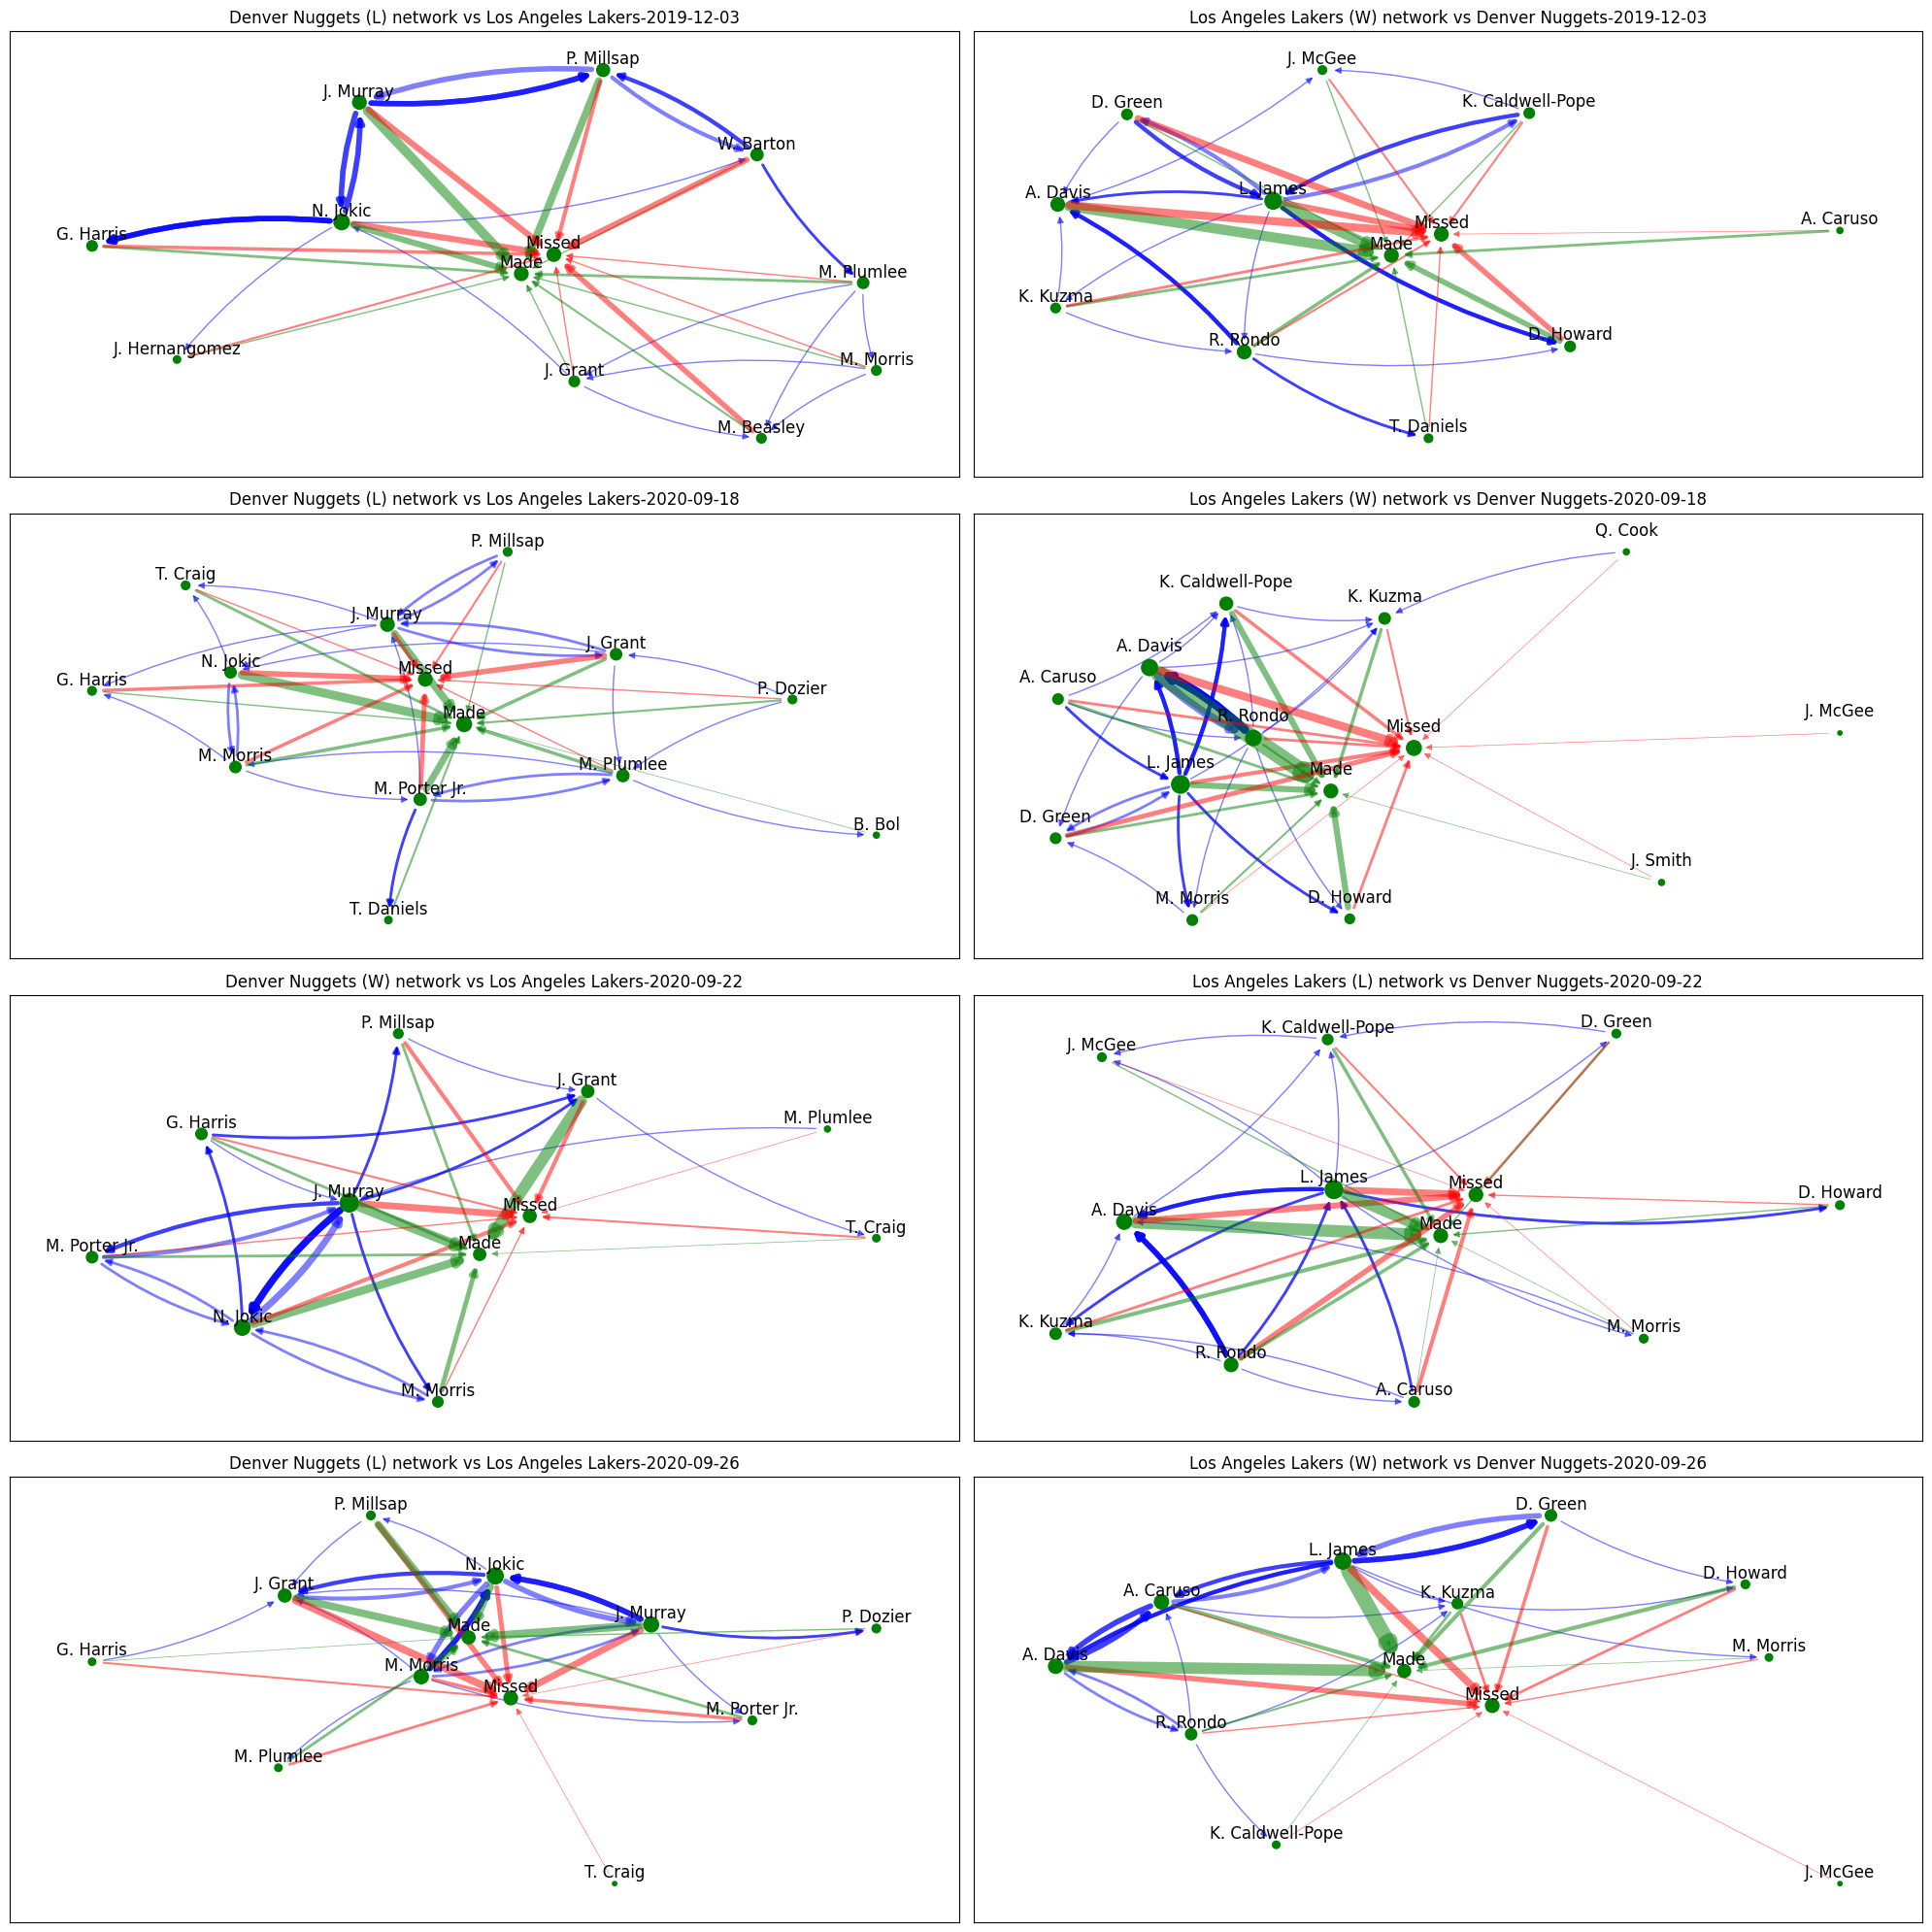

In [17]:
team_networks = {1610612743:{}, 1610612747:{}}
team_ids = {'DEN': 1610612743, 'LAL': 1610612747}

# Setup games of interest
games_list = ['0041900315', '0041900313', '0041900311', '0021900304']

# Filter out games that are not in the games list, sort by date from oldest to newest
interest_games = den_games.loc[den_games['GAME_ID'].isin(games_list)].sort_values(by='GAME_DATE')

plot_team_networks(interest_games, team_networks, team_ids, plot_name = 'shots_and_assists.png')

We can go through the networks and look at different metrics for every game.

In [105]:
def network_info(multidigraph):
    print(f"Network name: {multidigraph.name}")
    # Get the number of nodes
    num_nodes = multidigraph.number_of_nodes()
    # Get the number of edges
    num_edges = multidigraph.number_of_edges()

    # Get the number of shots and assists
    num_shots = len([(u, v, d) for u, v, d in multidigraph.edges(data=True) if d['action'] == 'shot'])
    num_assists = len([(u, v, d) for u, v, d in multidigraph.edges(data=True) if d['action'] == 'assist'])

    print(multidigraph.edges(data=True))
    # Get the number of made and missed shots
    shots = [(u, v, d) for u, v, d in multidigraph.edges(data=True) if d['action'] == 'shot']
    num_made_shots = np.sum([d['weight'] for u, v, d in shots if v == 1])
    num_missed_shots = np.sum([d['weight'] for u, v, d in shots if v == 2])
    num_free_throws = np.sum([d['weight'] for u, v, d in shots if d['actionType'] == 'freethrow'])


    print(f'Number of nodes: {num_nodes}')
    print(f'Number of edges: {num_edges}')
    print(f'Number of field shot attempts: {num_shots} ({num_made_shots} made, {num_missed_shots} missed)')
    print(f'Number of free throw attempts: {num_free_throws}', f'({num_made_shots} made, {num_missed_shots} missed)')
    print(f'Number of assists: {num_assists}')


def assist_deg_distrib(nw, ax):
    # Get all players but the made and missed nodes
    players = {node:data for node, data in nw.nodes(data=True) if node not in [1, 2]}

    # Get assist degree of players - InDegree
    #assist_degrees = [len(list(edge for frm, to, edge in nw.edges(node, data=True) if edge['action'] == 'assist')) for node in players]
    
    # Get allDegree of players
    assist_degrees = [len(list(edge for frm, to, edge in nw.edges(data=True) if edge['action'] == 'assist' and (frm == node or to==node) )) for node in players]

    # Put player names on the x axis (players -> data -> playerName)
    player_names = [players[node]['playerName'] for node in players]

    # Sort the players by assist degree
    player_names, assist_degrees = zip(*sorted(zip(player_names, assist_degrees), key=lambda x: x[1], reverse=True))

    # Plot the distribution on ax
    ax.bar(player_names, assist_degrees, width=0.5)
    ax.set_title(nw.name)
    ax.set_ylabel('Assist degree')

    # Set yticks more compact
    ax.set_yticks(np.arange(0, max(assist_degrees)+1, 1))

    # Rotate the x axis labels
    ax.set_xticklabels(player_names, rotation=60, fontsize=6)



[8, 2, 4, 0, 5, 0, 2, 3, 0, 2] [11, 7, 6, 4, 8, 1, 4, 5, 3, 3]


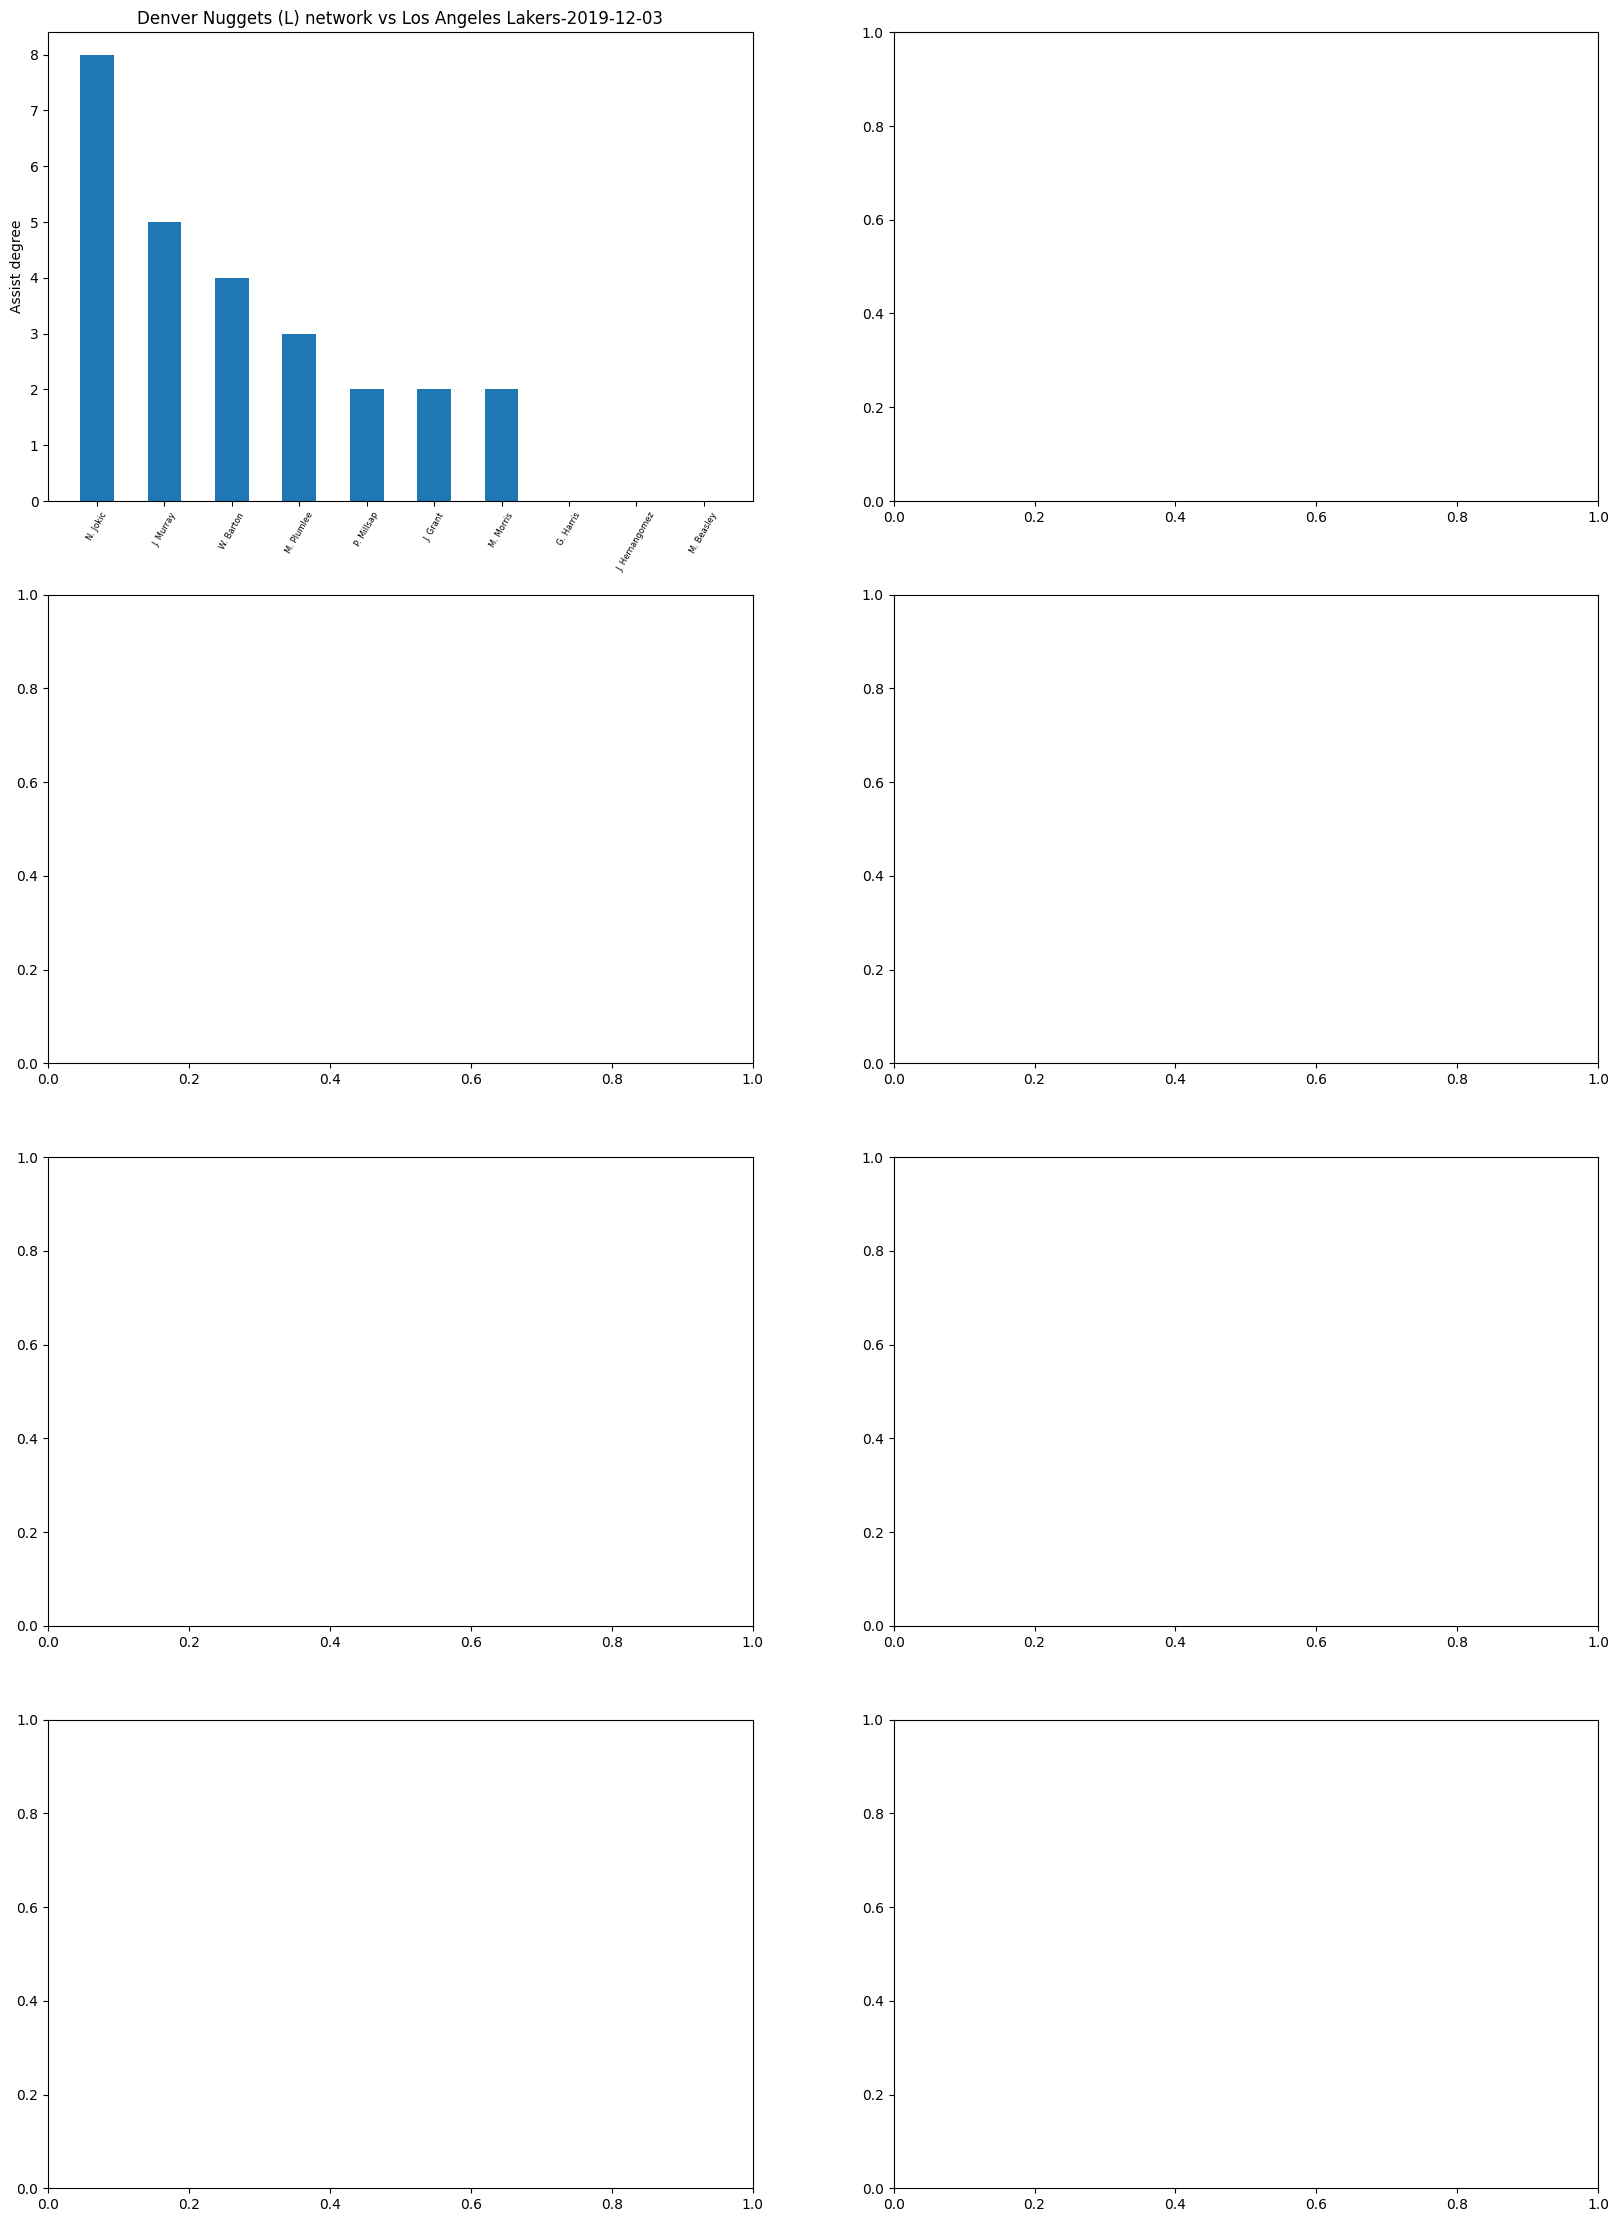

In [106]:
fig, axs = plt.subplots(nrows = len(interest_games),
                        ncols =2,
                        figsize= (20, 28),
                        )
for i, (team_id, networks) in enumerate(team_networks.items()):
    for j, (gameId, network) in enumerate(networks.items()):
        assist_deg_distrib(network, axs[j, i])

In [12]:
# Dataset created by the script from article https://github.com/AniMadurkar/NBA-Flow-Network-Analysis/tree/main
# Read data from csv
players = pd.read_csv(dataset_path + '/2019_Playoffs_Players.csv')
teams = pd.read_csv(dataset_path + '/2019_Playoffs.csv')
players

,Unnamed: 0,GAME_ID,PLAYER_ID,PLAYER_NAME_LAST_FIRST_home,TEAM_NAME_home,TEAM_ID_home,TEAM_ABBREVIATION_home,PASS_TYPE_home,G_home,PASS_TO_home,...,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,POSITION,mean,std
0,0,41900311,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,1,"Kuzma, Kyle",...,12.0,0.0,0.0,3.0,2.0,15.0,15.0,Forward,0.082776,0.098088
1,1,41900311,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,1,"Caruso, Alex",...,12.0,0.0,0.0,3.0,2.0,15.0,15.0,Forward,0.082776,0.098088
2,2,41900311,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,1,"Caldwell-Pope, Kentavious",...,12.0,0.0,0.0,3.0,2.0,15.0,15.0,Forward,0.082776,0.098088
3,3,41900311,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,1,"Davis, Anthony",...,12.0,0.0,0.0,3.0,2.0,15.0,15.0,Forward,0.082776,0.098088
4,4,41900311,2544,"James, LeBron",Los Angeles Lakers,1610612747,LAL,made,1,"Morris, Markieff",...,12.0,0.0,0.0,3.0,2.0,15.0,15.0,Forward,0.082776,0.098088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,266,41900315,1628398,"Kuzma, Kyle",Los Angeles Lakers,1610612747,LAL,made,1,"Caruso, Alex",...,1.0,0.0,1.0,0.0,3.0,8.0,0.0,Forward,0.082776,0.098088
267,267,41900315,1628398,"Kuzma, Kyle",Los Angeles Lakers,1610612747,LAL,made,1,"McGee, JaVale",...,1.0,0.0,1.0,0.0,3.0,8.0,0.0,Forward,0.082776,0.098088
268,268,41900315,1628398,"Kuzma, Kyle",Los Angeles Lakers,1610612747,LAL,made,1,"Rondo, Rajon",...,1.0,0.0,1.0,0.0,3.0,8.0,0.0,Forward,0.082776,0.098088
269,269,41900315,1628398,"Kuzma, Kyle",Los Angeles Lakers,1610612747,LAL,made,1,"Howard, Dwight",...,1.0,0.0,1.0,0.0,3.0,8.0,0.0,Forward,0.082776,0.098088


In [13]:
# Get stats from game 41900315
game_id = 41900315
game_players = players.loc[players['GAME_ID'] == game_id]
game_teams = teams.loc[teams['GAME_ID'] == game_id]
